#kaggle Titanic竞赛

In [1]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
#分析数据准备数据预处理
import pandas as pd

data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(data.shape,test.shape)

(891, 12) (418, 11)


In [3]:
from sklearn.model_selection import train_test_split

 #用sklearn把train数据分为train和eval两个子集
data_train,data_eval = train_test_split(data,test_size=0.2,shuffle=True)

print(data_train.shape,data_eval.shape)
data_train.head()

(712, 12) (179, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C
216,217,1,3,"Honkanen, Miss. Eliina",female,27.0,0,0,STON/O2. 3101283,7.9250,NaN,S
133,134,1,2,"Weisz, Mrs. Leopold (Mathilde Francoise Pede)",female,29.0,1,0,228414,26.0000,NaN,S
606,607,0,3,"Karaic, Mr. Milan",male,30.0,0,0,349246,7.8958,NaN,S
141,142,1,3,"Nysten, Miss. Anna Sofia",female,22.0,0,0,347081,7.7500,NaN,S


In [4]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install autogluon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 131.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [5]:
# 简单测试torch GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

PyTorch version: 2.6.0+cu124
CUDA version: 12.4
GPU available: True
GPU name: Tesla T4
GPU memory: 14.74 GB


In [6]:
import numpy as np

#特征工程和去噪方法
def enhanced_feature_engineering(data, is_train=True):
    """
    针对性的特征工程：只处理姓名和票号
    """
    df = data.copy()

    # 1. Tokenize the names
    if 'Name' in df.columns:
        # 使用正则表达式替换掉特殊符号，然后拆分
        df['Name_Tokens'] = df['Name'].str.replace('[,.]', ' ').str.split()

        # 提取头衔 (Mr., Mrs., Miss., etc.)
        df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

        # 将罕见头衔合并
        title_mapping = {
            'Mr': 'Mr',
            'Mrs': 'Mrs',
            'Miss': 'Miss',
            'Master': 'Master',
            'Dr': 'Rare',
            'Rev': 'Rare',
            'Col': 'Rare',
            'Major': 'Rare',
            'Mlle': 'Miss',
            'Countess': 'Rare',
            'Ms': 'Miss',
            'Lady': 'Rare',
            'Jonkheer': 'Rare',
            'Don': 'Rare',
            'Sir': 'Rare',
            'Capt': 'Rare',
            'Mme': 'Mrs',
            'Dona': 'Rare'
        }
        df['Title'] = df['Title'].map(title_mapping)
        df['Title'] = df['Title'].fillna('Unknown')

    # 2. Extract prefix from ticket
    if 'Ticket' in df.columns:
        # 使用正则表达式提取票号中的字母前缀部分
        df['Ticket_Prefix'] = df['Ticket'].str.extract('([A-Za-z./]+)', expand=False)
        df['Ticket_Prefix'] = df['Ticket_Prefix'].fillna('NONE')

        # 提取票号中的数字部分
        df['Ticket_Number'] = df['Ticket'].str.extract('(\d+)$', expand=False)
        df['Ticket_Number'] = df['Ticket_Number'].fillna(0).astype(int)

    # 基本特征处理（仍然需要基本清洗和填充）
    # 年龄异常值和缺失值处理
    if 'Age' in df.columns:
        df.loc[(df['Age'] < 0) | (df['Age'] > 100), 'Age'] = np.nan
        df['Age'] = df['Age'].fillna(df['Age'].median())

    # 票价异常值和缺失值处理
    if 'Fare' in df.columns:
        df.loc[df['Fare'] > 500, 'Fare'] = df['Fare'].median()
        df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    # 登船港口缺失值处理
    if 'Embarked' in df.columns:
        df['Embarked'] = df['Embarked'].fillna('S')

    # 选择建模特征
    base_features = [
        'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
        'Embarked', 'Title', 'Ticket_Prefix', 'Ticket_Number'
    ]

    # 根据是否为训练数据决定是否包含标签
    if is_train and 'Survived' in df.columns:
        final_features = base_features + ['Survived']
    else:
        final_features = base_features

    # 只选择存在的特征
    available_features = [f for f in final_features if f in df.columns]

    return df[available_features]

data_train = enhanced_feature_engineering(data_train)
data_eval = enhanced_feature_engineering(data_eval)

print(data_train.shape,data_eval.shape)
data_train.head()

(712, 11) (179, 11)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Ticket_Prefix,Ticket_Number,Survived
42,3,male,28.0,0,0,7.8958,C,Mr,NONE,349253,0
216,3,female,27.0,0,0,7.9250,S,Miss,STON/O,3101283,1
133,2,female,29.0,1,0,26.0000,S,Mrs,NONE,228414,1
606,3,male,30.0,0,0,7.8958,S,Mr,NONE,349246,0
141,3,female,22.0,0,0,7.7500,S,Miss,NONE,347081,1


In [14]:
import autogluon
from autogluon.tabular import TabularDataset, TabularPredictor


model = TabularPredictor(label='Survived').fit(
    data_train,
    presets='best_quality',
    auto_stack=True,
    included_model_types=['FASTAI', 'GBM'],
    time_limit=1800
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250603_005908"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          8
Memory Avail:       48.21 GB / 50.99 GB (94.5%)
Disk Space Avail:   193.34 GB / 235.68 GB (82.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will b

In [15]:
s_pred = model.predict(data_eval)
s_pred.head()

,Survived
205,1
471,0
334,1
312,1
326,0


In [16]:
model.evaluate(data_eval, silent=True)

{'accuracy': 0.8379888268156425,
 'balanced_accuracy': np.float64(0.830368906455863),
 'mcc': np.float64(0.6590035899396771),
 'roc_auc': np.float64(0.8926218708827405),
 'f1': 0.7913669064748201,
 'precision': 0.7857142857142857,
 'recall': 0.7971014492753623}

In [17]:
model.leaderboard(data_eval)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_r161_BAG_L1,0.843575,0.863764,accuracy,0.054717,0.055378,3.845149,0.054717,0.055378,3.845149,1,True,14
1,LightGBM_r121_BAG_L1,0.843575,0.865169,accuracy,0.067183,0.080165,3.848222,0.067183,0.080165,3.848222,1,True,32
2,LightGBM_r15_BAG_L1,0.837989,0.873596,accuracy,0.051686,0.048684,3.727173,0.051686,0.048684,3.727173,1,True,19
3,WeightedEnsemble_L2,0.837989,0.873596,accuracy,0.053060,0.049582,3.760479,0.001374,0.000899,0.033306,2,True,40
4,LightGBMLarge_BAG_L1,0.832402,0.851124,accuracy,0.063663,0.045476,4.442210,0.063663,0.045476,4.442210,1,True,4
5,NeuralNetFastAI_r4_BAG_L1,0.832402,0.858146,accuracy,0.088878,0.118325,6.742368,0.088878,0.118325,6.742368,1,True,36
6,LightGBM_r131_BAG_L1,0.826816,0.860955,accuracy,0.040833,0.048917,3.711200,0.040833,0.048917,3.711200,1,True,5
7,LightGBM_r188_BAG_L1,0.826816,0.849719,accuracy,0.041287,0.050655,3.450122,0.041287,0.050655,3.450122,1,True,9
8,NeuralNetFastAI_r172_BAG_L1,0.826816,0.851124,accuracy,0.098792,0.115845,6.171259,0.098792,0.115845,6.171259,1,True,33
9,LightGBM_BAG_L1,0.821229,0.862360,accuracy,0.027157,0.041121,3.465206,0.027157,0.041121,3.465206,1,True,2


In [18]:
#用训练好的模型预测测试集然后改为提交格式
test_processed = enhanced_feature_engineering(test, is_train=False)

predictions = model.predict(test_processed)
predictions.head()

,Survived
0,0
1,0
2,0
3,0
4,0


In [19]:
#修改为提交格式
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': predictions
})

submission.to_csv('submission.csv', index=False)
print("\n 提交文件已保存: submission.csv")


 提交文件已保存: submission.csv


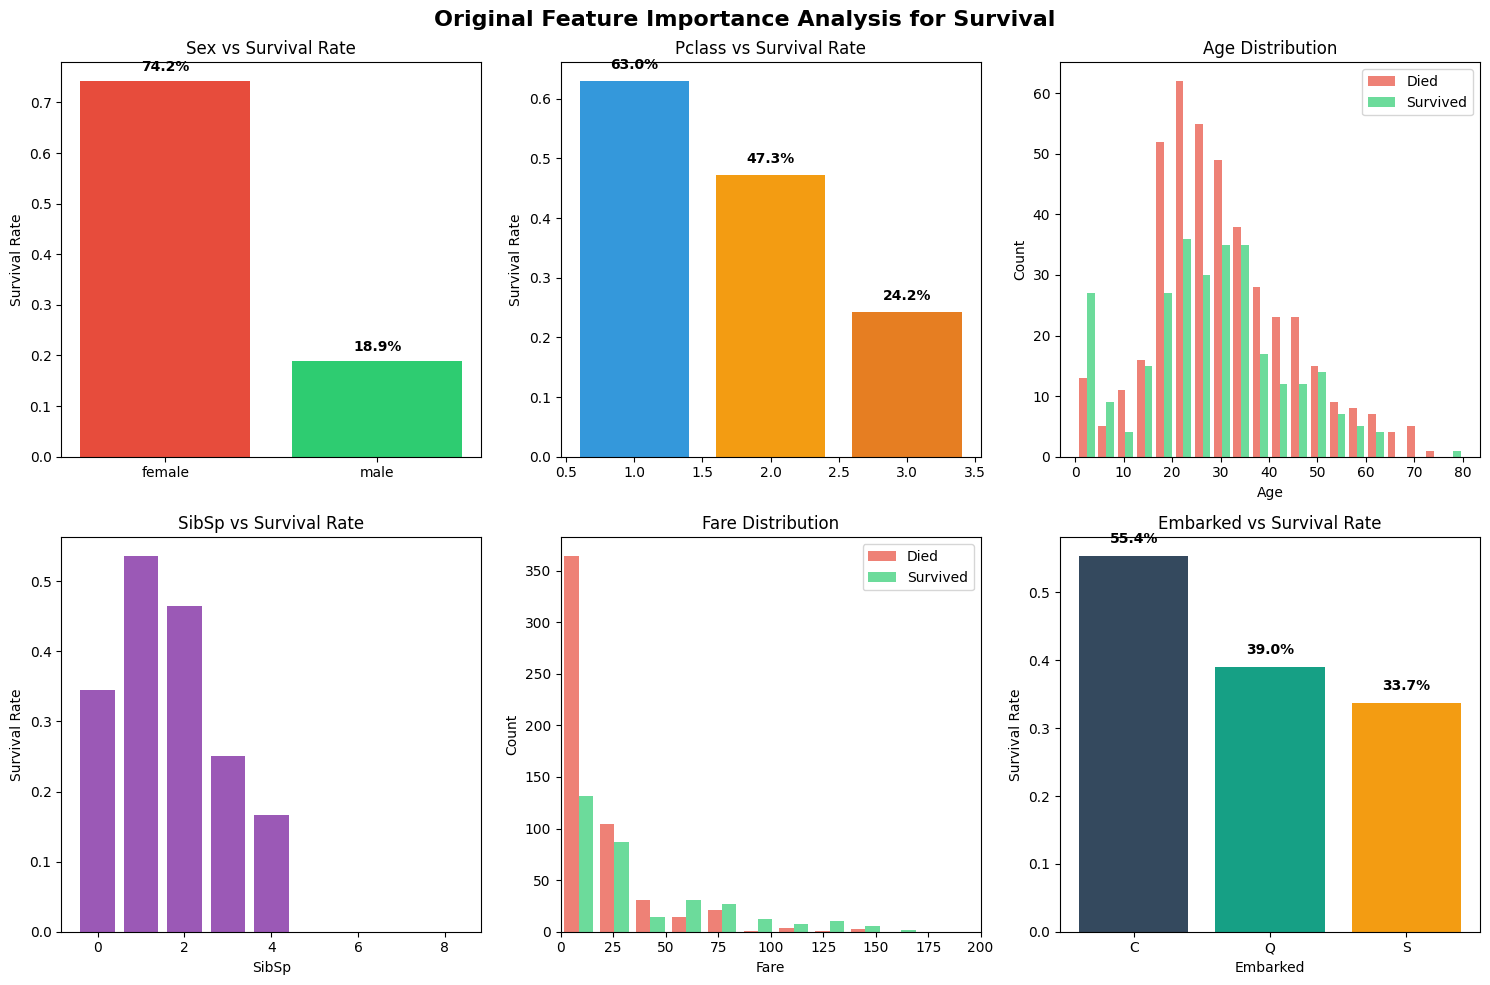

Original Feature Analysis:
1. Sex: Female 74.2% vs Male 18.9%
2. Pclass: 1st 63.0%, 2nd 47.3%, 3rd 24.2%
3. Age: Missing values 177 (19.9%)
4. Fare: Missing values 0
5. Embarked: Missing values 2
6. Cabin: Missing values 687 (77.1%)


In [15]:
#特征工程找重要参数
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def analyze_feature_importance(data):
    """
    原始特征重要性分析和可视化
    """
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Original Feature Importance Analysis for Survival', fontsize=16, fontweight='bold')

    # 1. Sex vs Survival
    sex_survival = data.groupby('Sex')['Survived'].mean()
    axes[0,0].bar(sex_survival.index, sex_survival.values, color=['#e74c3c', '#2ecc71'])
    axes[0,0].set_title('Sex vs Survival Rate')
    axes[0,0].set_ylabel('Survival Rate')
    for i, v in enumerate(sex_survival.values):
        axes[0,0].text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

    # 2. Pclass vs Survival
    class_survival = data.groupby('Pclass')['Survived'].mean()
    axes[0,1].bar(class_survival.index, class_survival.values, color=['#3498db', '#f39c12', '#e67e22'])
    axes[0,1].set_title('Pclass vs Survival Rate')
    axes[0,1].set_ylabel('Survival Rate')
    for i, v in enumerate(class_survival.values):
        axes[0,1].text(i+1, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

    # 3. Age Distribution
    age_data = data[data['Age'].notna()]
    survived_ages = age_data[age_data['Survived'] == 1]['Age']
    died_ages = age_data[age_data['Survived'] == 0]['Age']
    axes[0,2].hist([died_ages, survived_ages], bins=20, alpha=0.7,
                   color=['#e74c3c', '#2ecc71'], label=['Died', 'Survived'])
    axes[0,2].set_title('Age Distribution')
    axes[0,2].set_xlabel('Age')
    axes[0,2].set_ylabel('Count')
    axes[0,2].legend()

    # 4. SibSp vs Survival
    sibsp_survival = data.groupby('SibSp')['Survived'].mean()
    axes[1,0].bar(sibsp_survival.index, sibsp_survival.values, color='#9b59b6')
    axes[1,0].set_title('SibSp vs Survival Rate')
    axes[1,0].set_xlabel('SibSp')
    axes[1,0].set_ylabel('Survival Rate')

    # 5. Fare Distribution
    fare_data = data[data['Fare'].notna()]
    survived_fares = fare_data[fare_data['Survived'] == 1]['Fare']
    died_fares = fare_data[fare_data['Survived'] == 0]['Fare']
    axes[1,1].hist([died_fares, survived_fares], bins=30, alpha=0.7,
                   color=['#e74c3c', '#2ecc71'], label=['Died', 'Survived'])
    axes[1,1].set_title('Fare Distribution')
    axes[1,1].set_xlabel('Fare')
    axes[1,1].set_ylabel('Count')
    axes[1,1].set_xlim(0, 200)
    axes[1,1].legend()

    # 6. Embarked vs Survival
    embark_data = data[data['Embarked'].notna()]
    embark_survival = embark_data.groupby('Embarked')['Survived'].mean()
    axes[1,2].bar(embark_survival.index, embark_survival.values, color=['#34495e', '#16a085', '#f39c12'])
    axes[1,2].set_title('Embarked vs Survival Rate')
    axes[1,2].set_xlabel('Embarked')
    axes[1,2].set_ylabel('Survival Rate')
    for i, v in enumerate(embark_survival.values):
        axes[1,2].text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print original feature statistics
    print("Original Feature Analysis:")
    print("=" * 30)
    print(f"1. Sex: Female {sex_survival['female']:.1%} vs Male {sex_survival['male']:.1%}")
    print(f"2. Pclass: 1st {class_survival[1]:.1%}, 2nd {class_survival[2]:.1%}, 3rd {class_survival[3]:.1%}")
    print(f"3. Age: Missing values {data['Age'].isnull().sum()} ({data['Age'].isnull().sum()/len(data):.1%})")
    print(f"4. Fare: Missing values {data['Fare'].isnull().sum()}")
    print(f"5. Embarked: Missing values {data['Embarked'].isnull().sum()}")
    print(f"6. Cabin: Missing values {data['Cabin'].isnull().sum()} ({data['Cabin'].isnull().sum()/len(data):.1%})")

    return None

# Usage
importance_ranking = analyze_feature_importance(data)